In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
import os
import cv2
from pathlib import Path

In this model we try to use ResNet18 to approach a simple binary dataset composed of images with pneumonia and without

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
transform = transforms.Compose([
    #unlike the brain dataset, this one has thousands of samples thus data augmentation is not necessary
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

In [15]:
#set up dataset paths
root_dir = 'chest_xray'
train_data = datasets.ImageFolder(os.path.join(root_dir, 'train'), transform = transform)
val_data = datasets.ImageFolder(os.path.join(root_dir, 'val' ), transform= transform)
test_data = datasets.ImageFolder(os.path.join(root_dir, 'test'),transform = transform)

#loaders
train_loader = DataLoader(train_data, batch_size = 256, shuffle = True, num_workers= 4, pin_memory= True, persistent_workers= True)
val_loader = DataLoader(val_data, batch_size = 128, shuffle = True, num_workers= 2, pin_memory= True, persistent_workers= True)
test_loader = DataLoader(test_data, batch_size = 32)

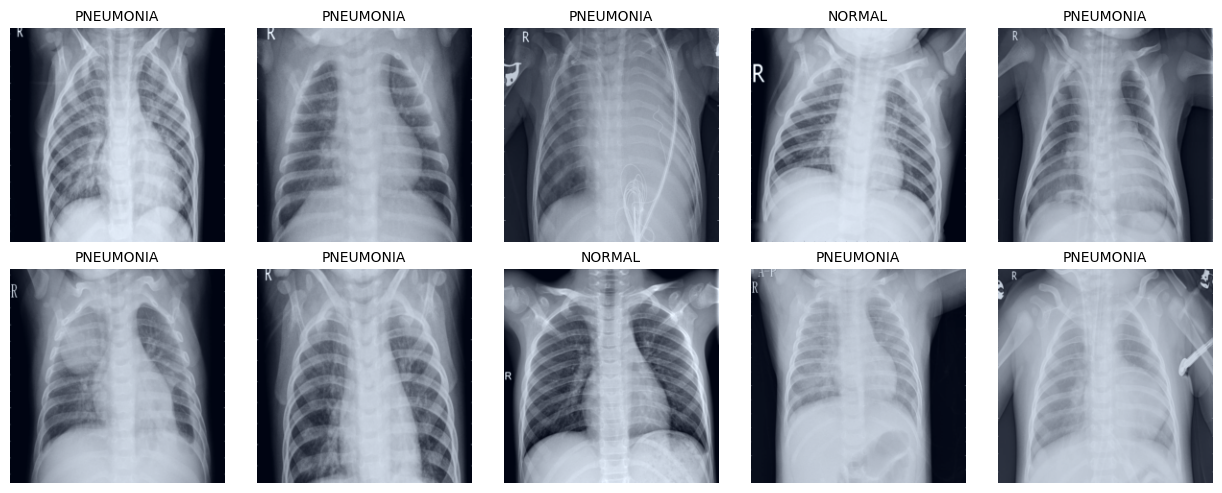

In [16]:
class_names = train_data.classes

# view some samples
def imshow_batch(inputs, classes, class_names, num_images=10):
    # displays a batch of images
    inputs = inputs[:num_images]
    classes = classes[:num_images]

    # Setup subplot grid
    rows = 2
    cols = (num_images + 1) // 2
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten()

    for idx, (img_tensor, label) in enumerate(zip(inputs, classes)):
        img = img_tensor.numpy().transpose((1, 2, 0))  # CHW → HWC
        img = (img * 0.229) + 0.485  # Unnormalize using ImageNet stats (approximate for visibility)
        img = np.clip(img, 0, 1)

        axes[idx].imshow(img)
        axes[idx].set_title(class_names[label], fontsize=10)
        axes[idx].axis('off')

    # Hide unused subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# display a sample batch from the train loader
inputs, classes = next(iter(train_loader))
imshow_batch(inputs, classes, class_names, num_images=10)


In [21]:
#load the pretrained resnet

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False


#modify the classifier for binary 
num_features = model.fc.in_features
#update num_features of final layer to 2
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr = 0.001)


In [23]:
#create the training loop
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set to training mode
            else:
                model.eval()   # set to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # accumulate loss and correct predictions
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))


In [24]:
train_model(model, {'train': train_loader, 'val': val_loader}, criterion, optimizer, num_epochs=10)


Epoch 1/10
train Loss: 0.5896 Acc: 0.7247
val Loss: 0.7059 Acc: 0.6250
Epoch 2/10
train Loss: 0.3311 Acc: 0.8662
val Loss: 0.8906 Acc: 0.5625
Epoch 3/10
train Loss: 0.2457 Acc: 0.9087
val Loss: 0.7635 Acc: 0.5625
Epoch 4/10
train Loss: 0.2132 Acc: 0.9178
val Loss: 0.6308 Acc: 0.6250
Epoch 5/10
train Loss: 0.1931 Acc: 0.9268
val Loss: 0.5593 Acc: 0.5625
Epoch 6/10
train Loss: 0.1804 Acc: 0.9289
val Loss: 0.5376 Acc: 0.5625
Epoch 7/10
train Loss: 0.1706 Acc: 0.9321
val Loss: 0.4661 Acc: 0.6250
Epoch 8/10
train Loss: 0.1633 Acc: 0.9348
val Loss: 0.5104 Acc: 0.6250
Epoch 9/10
train Loss: 0.1540 Acc: 0.9396
val Loss: 0.5292 Acc: 0.6875
Epoch 10/10
train Loss: 0.1484 Acc: 0.9413
val Loss: 0.5099 Acc: 0.6875


In [28]:
def eval_model(model, dataloader):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _,preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("Classification Summary:")
    print(classification_report(y_true, y_pred, target_names = class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

eval_model(model, test_loader)

Classification Summary:
              precision    recall  f1-score   support

      NORMAL       0.94      0.56      0.70       234
   PNEUMONIA       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.77      0.79       624
weighted avg       0.84      0.82      0.81       624

Confusion Matrix:
[[132 102]
 [  9 381]]


In [48]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []
    
    def _forward_hook(self, module, input, output):
        self.activations = output.detach()
    
    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach() if grad_output[0] is not None else None
    
    def generate_cam(self, input_tensor, class_idx=None):
        # Clear any existing hooks first
        self.remove_hooks()
        
        # Register fresh hooks
        forward_handle = self.target_layer.register_forward_hook(self._forward_hook)
        backward_handle = self.target_layer.register_backward_hook(self._backward_hook)
        self.hooks = [forward_handle, backward_handle]
        
        try:
            # Ensure model is in eval mode but with gradients enabled
            self.model.eval()
            
            # Clear previous gradients
            self.model.zero_grad()
            
            # Forward pass
            input_tensor.requires_grad_(True)
            output = self.model(input_tensor)
            
            # Get class index if not provided
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()
            
            # Backward pass for specific class
            score = output[0, class_idx]
            score.backward(retain_graph=True)
            
            # Check if gradients were captured
            if self.gradients is None or self.activations is None:
                raise RuntimeError("Failed to capture gradients or activations")
            
            # Generate CAM
            gradients = self.gradients[0]  # Remove batch dimension
            activations = self.activations[0]  # Remove batch dimension
            
            # Global average pooling of gradients
            weights = torch.mean(gradients, dim=(1, 2))
            
            # Weighted combination of activation maps
            cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=activations.device)
            for i, w in enumerate(weights):
                cam += w * activations[i]
            
            # Apply ReLU
            cam = F.relu(cam)
            
            # Normalize
            cam = cam - cam.min()
            if cam.max() > 0:
                cam = cam / cam.max()
            
            return cam.cpu().numpy(), class_idx
            
        finally:
            # Always clean up hooks
            self.remove_hooks()
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    # Keep original for visualization
    original = np.array(image)
    # Apply transforms
    tensor = transform(image).unsqueeze(0).to(device)
    return tensor, original

def generate_gradcam_visualization(model, image_path, target_class=None):
    # Initialize GradCAM
    target_layer = model.layer4[1].conv2  # Last conv layer before FC
    grad_cam = GradCAM(model, target_layer)
    
    # Preprocess image
    input_tensor, original_image = preprocess_image(image_path)
    
    # Generate CAM (hooks are managed inside generate_cam)
    cam, predicted_class = grad_cam.generate_cam(input_tensor, target_class)
    
    # Resize CAM to match input image size
    cam_resized = cv2.resize(cam, (224, 224))
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    original_resized = cv2.resize(original_image, (224, 224))
    axes[0].imshow(original_resized)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Heatmap
    axes[1].imshow(cam_resized, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')
    
    # Overlay
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Ensure original_resized is uint8
    if original_resized.dtype != np.uint8:
        original_resized = (original_resized * 255).astype(np.uint8)
    
    overlay = cv2.addWeighted(original_resized, 0.6, heatmap_rgb, 0.4, 0)
    axes[2].imshow(overlay)
    axes[2].set_title(f'Overlay - Predicted: {class_names[predicted_class]}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return cam_resized, predicted_class


Actual label: PNEUMONIA
Forward hook called
Forward hook called
Forward hook called
Forward hook called
Forward hook called
Forward hook called


c:\Users\Jomar\VSCode\ML\BasicML\ML\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Backward hook called
Backward hook called
Backward hook called


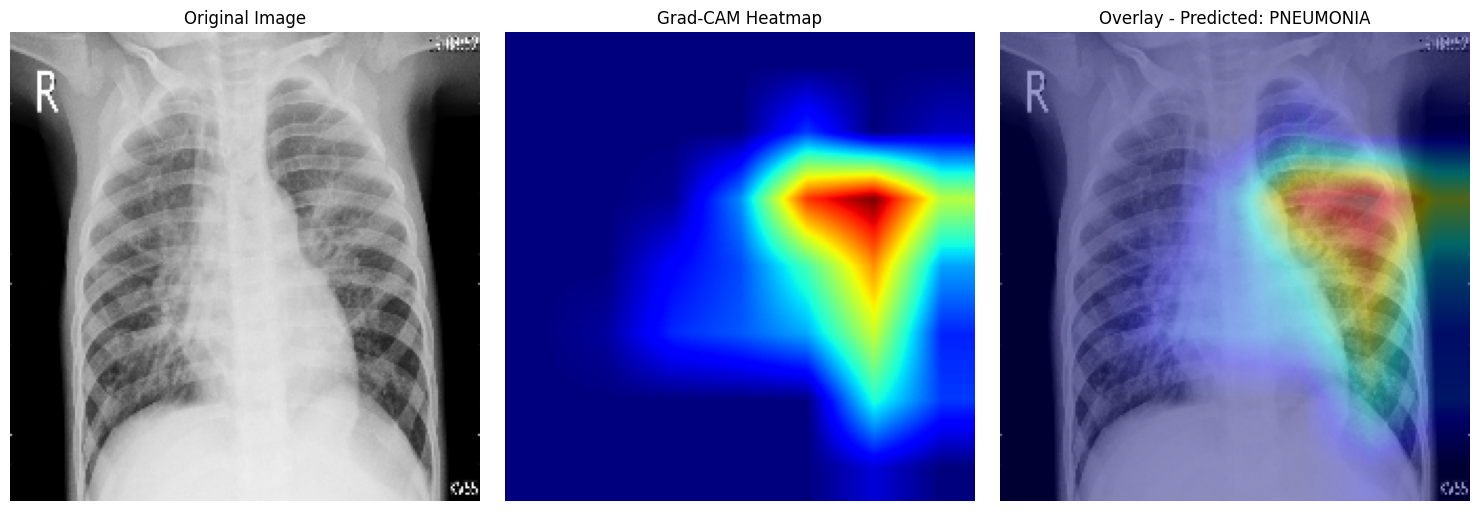

Predicted class: PNEUMONIA


In [49]:
import random

# Make sure model parameters require gradients for Grad-CAM
for param in model.parameters():
    param.requires_grad = True

# Test the fixed implementation
image_path, label = test_data.samples[random.randint(0, len(test_data) - 1)]
print(f"Actual label: {test_data.classes[label]}")
cam, predicted_class = generate_gradcam_visualization(model, image_path)
print(f"Predicted class: {class_names[predicted_class]}")

# Function to test multiple images
def test_gradcam_multiple_images(model, test_data, num_images=5):
    """Test Grad-CAM on multiple random images"""
    indices = random.sample(range(len(test_data)), num_images)
    
    for i, idx in enumerate(indices):
        print(f"\n--- Image {i+1} ---")
        image_path, label = test_data.samples[idx]
        print(f"Actual label: {test_data.classes[label]}")
        
        cam, predicted_class = generate_gradcam_visualization(model, image_path)
        print(f"Predicted class: {class_names[predicted_class]}")
        print(f"Correct prediction: {label == predicted_class}")
